In [2]:
using ITensors
import TensorCrossInterpolation as TCI
using TCIITensorConversion
using QuanticsGrids
using Plots
include("../../src/functions.jl")

packages uploaded
------------------------------


functions uploaded
------------------------------


In [118]:
n = 35
s_i = [Index(2,"init_n=$j") for j=1:n]
t = [Index(2,"final_n=$j") for j=1:n]


35-element Vector{Index{Int64}}:
 (dim=2|id=964|"final_n=1")
 (dim=2|id=703|"final_n=2")
 (dim=2|id=148|"final_n=3")
 (dim=2|id=110|"final_n=4")
 (dim=2|id=139|"final_n=5")
 (dim=2|id=251|"final_n=6")
 (dim=2|id=745|"final_n=7")
 (dim=2|id=785|"final_n=8")
 (dim=2|id=331|"final_n=9")
 (dim=2|id=118|"final_n=10")
 ⋮
 (dim=2|id=832|"final_n=27")
 (dim=2|id=857|"final_n=28")
 (dim=2|id=937|"final_n=29")
 (dim=2|id=87|"final_n=30")
 (dim=2|id=391|"final_n=31")
 (dim=2|id=839|"final_n=32")
 (dim=2|id=463|"final_n=33")
 (dim=2|id=710|"final_n=34")
 (dim=2|id=65|"final_n=35")

In [221]:
function Generate_QFT_MPOs(n::Int,  s_i::Vector{<:Index}, s_f::Vector{<:Index})
    G = []
    #################
    #   G1, i =  1   #
    #################
    i = 1
    l1 = [Index(2,"Link,QFT,i=$i,j=$j") for j=1:n-1]
    l = l1
    s1 = s_i
    s2 = [Index(2,"phy,QFT,i=$(i),j=$j") for j=1:n]
    Q = MPO(n)
    A = ITensor(s1[1],s2[1],l[1])
    A[1,1,1] = 1/sqrt(2)
    A[1,2,1] = 1/sqrt(2)
    A[2,1,2] = 1/sqrt(2)
    A[2,2,2] = -1/sqrt(2)
    Q[1] = A
    for j in 2:n-1
        A = ITensor(ComplexF64,l[j-1],s1[j],s2[j],l[j])
        A[1,1,1,1] = 1
        A[1,2,2,1] = 1
        A[2,1,1,2] = 1
        A[2,2,2,2] = exp(1im* 2π/2^j)
        Q[j] = A
    end
    A = ITensor(ComplexF64,l[n-1],s1[n],s2[n])
    A[1,1,1] = 1
    A[1,2,2] = 1
    A[2,1,1] = 1
    A[2,2,2] = exp(1im * 2π/2^n) 
    Q[n] = A 
    push!(G,Q)
    i += 1
    #####################
    #    i =  2:n-1     #
    #####################
    for _ in range(2,n-1)
        l1 = [Index(1,"Link,QFT,i=$i,j=$j") for j=1:i-1]
        l2 = [Index(2,"Link,QFT,i=$i,j=$j") for j=i:n-1]
        l = [l1;l2]
        s1 = s2
        s2 = [Index(2,"phy,QFT,i=$(i),j=$j") for j=1:n]
        Q = MPO(n)
        #j = 1
        j = 1
        A = ITensor(s1[1],s2[1],l[1])
        A[1,1,1] = 1
        A[2,2,1] = 1  
        Q[1] = A
        j += 1
        #j =2:i-1
        for _ in range(2,i-1)
            A = ITensor(l[j-1],s1[j],s2[j],l[j])
            A[1,1,1,1] = 1
            A[1,2,2,1] = 1
            Q[j] = A
            j += 1
        end
        #j = i 
        A = ITensor(l[i-1],s1[i],s2[i],l[i])
        A[1,1,1,1] = 1/sqrt(2)
        A[1,1,2,1] = 1/sqrt(2)
        A[1,2,1,2] = 1/sqrt(2)
        A[1,2,2,2] = -1/sqrt(2)
        Q[i] = A
        j += 1
        #j = i+1:n-1
        for k in range(2,n-i)
            A = ITensor(ComplexF64,l[j-1],s1[j],s2[j],l[j])
            A[1,1,1,1] = 1
            A[1,2,2,1] = 1
            A[2,1,1,2] = 1
            A[2,2,2,2] = exp(1im * 2π/2^k)
            Q[j] = A
            j += 1
        end
        # j = n
        A = ITensor(ComplexF64,l[n-1],s1[n],s2[n])
        A[1,1,1] = 1
        A[1,2,2] = 1
        A[2,1,1] = 1
        A[2,2,2] = exp(1im* 2π/2^(n-i+1)) 
        Q[n] = A
        push!(G,Q)
        i += 1
    end
    #################
    #    i =  n     #
    #################
    l1 = [Index(1,"Link,QFT,i=$i,j=$j") for j=1:n-1]
    l = l1
    s1 = s2
    s2 = s_f
    Q = MPO(n)
    j = 1
    #j = 1
    
    A = ITensor(s1[1],s2[1],l[1])
    A[1,1,1] = 1
    A[2,2,1] = 1
    Q[1] = A
    
    #j = 2:n-1
    for j in range(2,n-1)
        A = ITensor(l[j-1],s1[j],s2[j],l[j])
        
        A[1,1,1,1] = 1
        A[1,2,2,1] = 1
        Q[j] = A
    end
    
    # j = n
    A = ITensor(l[n-1],s1[n],s2[n])
    A[1,1,1] = 1/sqrt(2)
    A[1,1,2] = 1/sqrt(2)
    A[1,2,1] = 1/sqrt(2)
    A[1,2,2] = -1/sqrt(2)
    Q[n] = A
    push!(G,Q)
    return G
end

Generate_QFT_MPOs (generic function with 1 method)

In [254]:
Gs = Generate_QFT_MPOs(n,s_i,t)

20-element Vector{Any}:
 MPO
[1] ((dim=2|id=174|"init_n=1"), (dim=2|id=265|"QFT,i=1,j=1,phy"), (dim=2|id=405|"Link,QFT,i=1,j=1"))
[2] ((dim=2|id=405|"Link,QFT,i=1,j=1"), (dim=2|id=781|"init_n=2"), (dim=2|id=235|"QFT,i=1,j=2,phy"), (dim=2|id=688|"Link,QFT,i=1,j=2"))
[3] ((dim=2|id=688|"Link,QFT,i=1,j=2"), (dim=2|id=466|"init_n=3"), (dim=2|id=722|"QFT,i=1,j=3,phy"), (dim=2|id=492|"Link,QFT,i=1,j=3"))
[4] ((dim=2|id=492|"Link,QFT,i=1,j=3"), (dim=2|id=180|"init_n=4"), (dim=2|id=833|"QFT,i=1,j=4,phy"), (dim=2|id=625|"Link,QFT,i=1,j=4"))
[5] ((dim=2|id=625|"Link,QFT,i=1,j=4"), (dim=2|id=232|"init_n=5"), (dim=2|id=778|"QFT,i=1,j=5,phy"), (dim=2|id=288|"Link,QFT,i=1,j=5"))
[6] ((dim=2|id=288|"Link,QFT,i=1,j=5"), (dim=2|id=580|"init_n=6"), (dim=2|id=614|"QFT,i=1,j=6,phy"), (dim=2|id=60|"Link,QFT,i=1,j=6"))
[7] ((dim=2|id=60|"Link,QFT,i=1,j=6"), (dim=2|id=558|"init_n=7"), (dim=2|id=36|"QFT,i=1,j=7,phy"), (dim=2|id=393|"Link,QFT,i=1,j=7"))
[8] ((dim=2|id=393|"Link,QFT,i=1,j=7"), (dim=2|id=987|"in

In [255]:
println(Gs[1][4])

ITensor ord=4
Dim 1: (dim=2|id=492|"Link,QFT,i=1,j=3")
Dim 2: (dim=2|id=180|"init_n=4")
Dim 3: (dim=2|id=833|"QFT,i=1,j=4,phy")
Dim 4: (dim=2|id=625|"Link,QFT,i=1,j=4")
NDTensors.Dense{ComplexF64, Vector{ComplexF64}}
 2×2×2×2
[:, :, 1, 1] =
 1.0 + 0.0im  0.0 + 0.0im
 0.0 + 0.0im  0.0 + 0.0im

[:, :, 2, 1] =
 0.0 + 0.0im  1.0 + 0.0im
 0.0 + 0.0im  0.0 + 0.0im

[:, :, 1, 2] =
 0.0 + 0.0im  0.0 + 0.0im
 1.0 + 0.0im  0.0 + 0.0im

[:, :, 2, 2] =
 0.0 + 0.0im                 0.0 + 0.0im
 0.0 + 0.0im  0.9238795325112867 + 0.3826834323650898im


In [256]:
function QFT(n::Int,  s_i::Vector{<:Index}, s_f::Vector{<:Index})
    Gs = Generate_QFT_MPOs(n,s_i,s_f)
    G = contract(Gs[1],Gs[2])
    for i in range(3,n)
        G = contract(G,Gs[i])
    end
    return G
end

QFT (generic function with 1 method)

In [257]:
qft = QFT(n,s_i,t)

MPO
[1] ((dim=2|id=174|"init_n=1"), (dim=2|id=67|"n=1"), (dim=2|id=762|"Link,QFT,i=1,j=1"))
[2] ((dim=2|id=781|"init_n=2"), (dim=2|id=928|"n=2"), (dim=4|id=335|"Link,QFT,i=1,j=2"), (dim=2|id=762|"Link,QFT,i=1,j=1"))
[3] ((dim=2|id=466|"init_n=3"), (dim=2|id=5|"n=3"), (dim=7|id=423|"Link,QFT,i=1,j=3"), (dim=4|id=335|"Link,QFT,i=1,j=2"))
[4] ((dim=2|id=180|"init_n=4"), (dim=2|id=968|"n=4"), (dim=8|id=89|"Link,QFT,i=1,j=4"), (dim=7|id=423|"Link,QFT,i=1,j=3"))
[5] ((dim=2|id=232|"init_n=5"), (dim=2|id=527|"n=5"), (dim=8|id=646|"Link,QFT,i=1,j=5"), (dim=8|id=89|"Link,QFT,i=1,j=4"))
[6] ((dim=2|id=580|"init_n=6"), (dim=2|id=633|"n=6"), (dim=8|id=955|"Link,QFT,i=1,j=6"), (dim=8|id=646|"Link,QFT,i=1,j=5"))
[7] ((dim=2|id=558|"init_n=7"), (dim=2|id=801|"n=7"), (dim=8|id=900|"Link,QFT,i=1,j=7"), (dim=8|id=955|"Link,QFT,i=1,j=6"))
[8] ((dim=2|id=987|"init_n=8"), (dim=2|id=860|"n=8"), (dim=8|id=382|"Link,QFT,i=1,j=8"), (dim=8|id=900|"Link,QFT,i=1,j=7"))
[9] ((dim=2|id=176|"init_n=9"), (dim=2|id=85

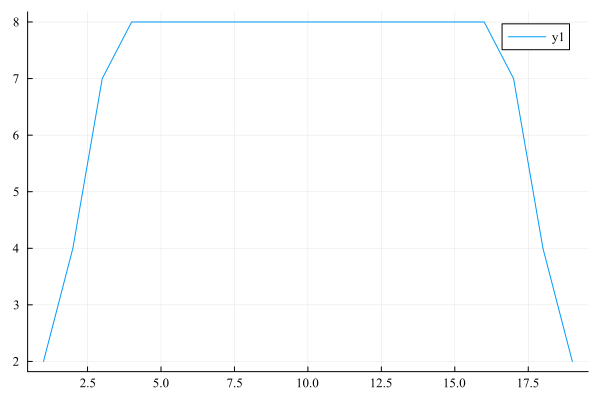

In [258]:
plot(linkdims(qft))

In [241]:
siteinds(qft)

20-element Vector{Vector{Index{Int64}}}:
 [(dim=2|id=174|"init_n=1"), (dim=2|id=636|"final_n=1")]
 [(dim=2|id=781|"init_n=2"), (dim=2|id=357|"final_n=2")]
 [(dim=2|id=466|"init_n=3"), (dim=2|id=910|"final_n=3")]
 [(dim=2|id=180|"init_n=4"), (dim=2|id=346|"final_n=4")]
 [(dim=2|id=232|"init_n=5"), (dim=2|id=986|"final_n=5")]
 [(dim=2|id=580|"init_n=6"), (dim=2|id=853|"final_n=6")]
 [(dim=2|id=558|"init_n=7"), (dim=2|id=810|"final_n=7")]
 [(dim=2|id=987|"init_n=8"), (dim=2|id=702|"final_n=8")]
 [(dim=2|id=176|"init_n=9"), (dim=2|id=989|"final_n=9")]
 [(dim=2|id=174|"init_n=10"), (dim=2|id=162|"final_n=10")]
 [(dim=2|id=520|"init_n=11"), (dim=2|id=985|"final_n=11")]
 [(dim=2|id=370|"init_n=12"), (dim=2|id=820|"final_n=12")]
 [(dim=2|id=450|"init_n=13"), (dim=2|id=705|"final_n=13")]
 [(dim=2|id=72|"init_n=14"), (dim=2|id=413|"final_n=14")]
 [(dim=2|id=11|"init_n=15"), (dim=2|id=61|"final_n=15")]
 [(dim=2|id=40|"init_n=16"), (dim=2|id=81|"final_n=16")]
 [(dim=2|id=207|"init_n=17"), (dim=2|i

In [259]:
function evaluate_MPO(M::MPO,s_i::Vector{<:Index}, s_f::Vector{<:Index}, v)
  s = s_i
  V = MPS(s)  
  for (j,sj) in enumerate(s)
    if sj !== nothing
      V[j] = M[j]*onehot(s[j]=>v[j])
    end
  end
  return truncate!(V)
end

evaluate_MPO (generic function with 2 methods)

**Example**

In [4]:
L = n

g(x) = exp10(-(x+3)^2/2)
x_max = 10


function f(v)
    x = b2c(v)
    y = 2*x_max * (x- 1/2)
    return g(y)
end

localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

tolerance = 1e-11

tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance, maxbonddim = 100)

mps_f = MPS(tci)

MPS
[1] ((dim=2|id=786|"n=1"), (dim=2|id=279|"l=1,link"))
[2] ((dim=2|id=279|"l=1,link"), (dim=2|id=539|"n=2"), (dim=3|id=367|"l=2,link"))
[3] ((dim=3|id=367|"l=2,link"), (dim=2|id=384|"n=3"), (dim=5|id=426|"l=3,link"))
[4] ((dim=5|id=426|"l=3,link"), (dim=2|id=190|"n=4"), (dim=7|id=960|"l=4,link"))
[5] ((dim=7|id=960|"l=4,link"), (dim=2|id=287|"n=5"), (dim=10|id=790|"l=5,link"))
[6] ((dim=10|id=790|"l=5,link"), (dim=2|id=663|"n=6"), (dim=9|id=848|"l=6,link"))
[7] ((dim=9|id=848|"l=6,link"), (dim=2|id=506|"n=7"), (dim=8|id=200|"l=7,link"))
[8] ((dim=8|id=200|"l=7,link"), (dim=2|id=158|"n=8"), (dim=7|id=320|"l=8,link"))
[9] ((dim=7|id=320|"l=8,link"), (dim=2|id=93|"n=9"), (dim=6|id=54|"l=9,link"))
[10] ((dim=6|id=54|"l=9,link"), (dim=2|id=175|"n=10"), (dim=5|id=941|"l=10,link"))
[11] ((dim=5|id=941|"l=10,link"), (dim=2|id=427|"n=11"), (dim=5|id=97|"l=11,link"))
[12] ((dim=5|id=97|"l=11,link"), (dim=2|id=385|"n=12"), (dim=4|id=983|"l=12,link"))
[13] ((dim=4|id=983|"l=12,link"), (dim=2|id

In [5]:
Fs = []
x_range = LinRange(-x_max,x_max,500)
for x in x_range
    s = c2b(x/(2x_max) + 1/2 ,L) 
    push!(Fs , evaluate(mps_f,s))
end

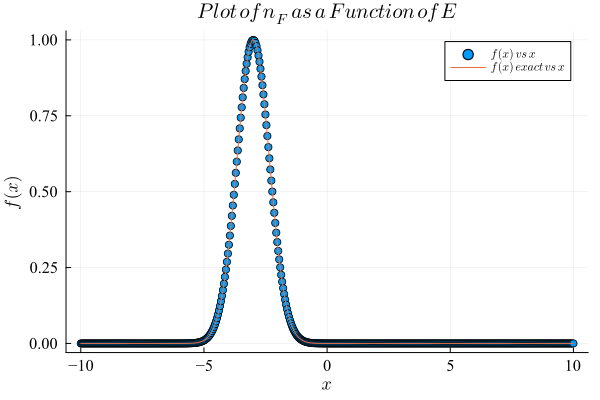

In [6]:
using Plots
using LaTeXStrings

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")

p = scatter(x_range, Fs, label=L"f(x) \, \textit{vs} \,x", xlabel=L"x", ylabel=L"f(x)", 
    title=L"Plot \, of \, n_F \, \textit{as} \, a \, \textit{Function} \, of \, E", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot
    plot!(x_range, g.(x_range), label=L"f(x) \, \textit{exact} \, \textit{vs} \, x", 
        legend=:topright,
        titlefont=14, guidefont=12, tickfont=10)
display(p)

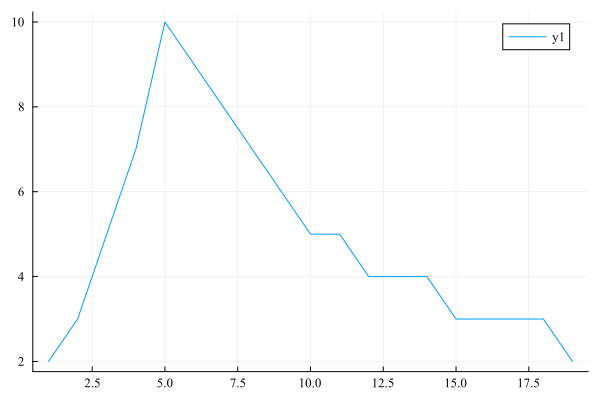

In [264]:
plot(linkdims(mps_f))

In [299]:
t = siteinds(mps_f)
qft = QFT(n,s_i,t)
qft_mps_f = apply(qft, mps_f)

20-element Vector{Index{Int64}}:
 (dim=2|id=251|"n=1")
 (dim=2|id=456|"n=2")
 (dim=2|id=818|"n=3")
 (dim=2|id=901|"n=4")
 (dim=2|id=637|"n=5")
 (dim=2|id=691|"n=6")
 (dim=2|id=502|"n=7")
 (dim=2|id=302|"n=8")
 (dim=2|id=590|"n=9")
 (dim=2|id=802|"n=10")
 (dim=2|id=815|"n=11")
 (dim=2|id=129|"n=12")
 (dim=2|id=900|"n=13")
 (dim=2|id=159|"n=14")
 (dim=2|id=820|"n=15")
 (dim=2|id=85|"n=16")
 (dim=2|id=658|"n=17")
 (dim=2|id=821|"n=18")
 (dim=2|id=280|"n=19")
 (dim=2|id=384|"n=20")

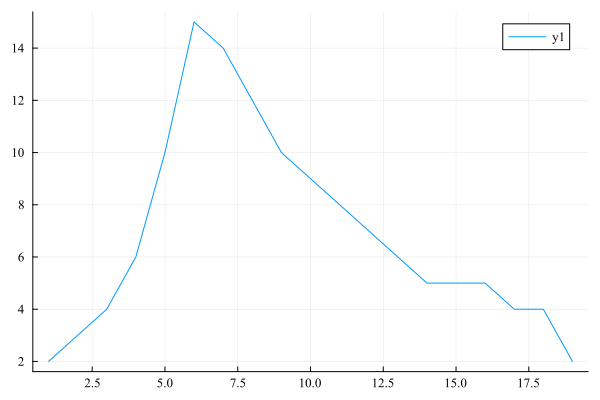

In [301]:
plot(linkdims(qft_mps_f))

In [10]:
Fk = []
k_range = LinRange(-x_max,x_max,500)
for x in x_range
    s = c2b(x/(2x_max) + 1/2 ,L) 
    reverse!(s)
    push!(Fk , evaluate(qft_mps_f,s))
end

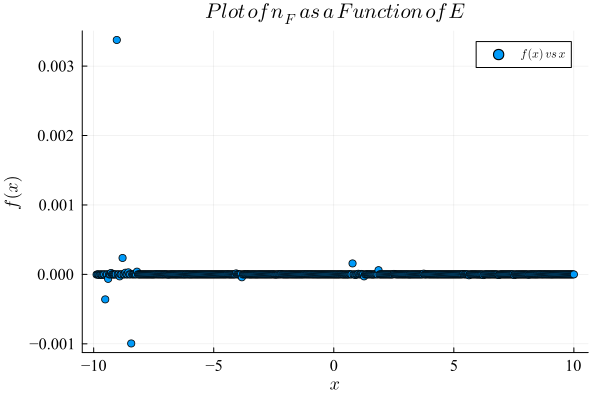

In [11]:
using Plots
using LaTeXStrings

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")

p = scatter(x_range[4:end], real.(Fk[4:end]), label=L"f(x) \, \textit{vs} \,x", xlabel=L"x", ylabel=L"f(x)", 
    title=L"Plot \, of \, n_F \, \textit{as} \, a \, \textit{Function} \, of \, E", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot
    
display(p)

# New approach


In [119]:
Lx = n
Lk = n

L = Int(Lk + Lx)
g(x,k) = exp(1im * k * x)
x_max = 10
k_max = 10

function f(v)
    x0 = b2c(v[1:Lx])
    k0 = b2c(v[Lx+1:end])
    x = 2*x_max * (x0-1/2)
    k = 2*k_max * (k0-1/2)
    return g(x,k)
end

localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

tolerance = 1e-11

tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance, maxbonddim = 250)

mps_QFT = MPS(tci)

MPS
[1] ((dim=2|id=276|"n=1"), (dim=2|id=724|"l=1,link"))
[2] ((dim=2|id=724|"l=1,link"), (dim=2|id=989|"n=2"), (dim=4|id=283|"l=2,link"))
[3] ((dim=4|id=283|"l=2,link"), (dim=2|id=163|"n=3"), (dim=8|id=441|"l=3,link"))
[4] ((dim=8|id=441|"l=3,link"), (dim=2|id=161|"n=4"), (dim=16|id=242|"l=4,link"))
[5] ((dim=16|id=242|"l=4,link"), (dim=2|id=457|"n=5"), (dim=32|id=390|"l=5,link"))
[6] ((dim=32|id=390|"l=5,link"), (dim=2|id=942|"n=6"), (dim=64|id=517|"l=6,link"))
[7] ((dim=64|id=517|"l=6,link"), (dim=2|id=541|"n=7"), (dim=88|id=713|"l=7,link"))
[8] ((dim=88|id=713|"l=7,link"), (dim=2|id=134|"n=8"), (dim=91|id=941|"l=8,link"))
[9] ((dim=91|id=941|"l=8,link"), (dim=2|id=942|"n=9"), (dim=92|id=730|"l=9,link"))
[10] ((dim=92|id=730|"l=9,link"), (dim=2|id=619|"n=10"), (dim=92|id=157|"l=10,link"))
[11] ((dim=92|id=157|"l=10,link"), (dim=2|id=635|"n=11"), (dim=92|id=918|"l=11,link"))
[12] ((dim=92|id=918|"l=11,link"), (dim=2|id=326|"n=12"), (dim=92|id=482|"l=12,link"))
[13] ((dim=92|id=482|"l

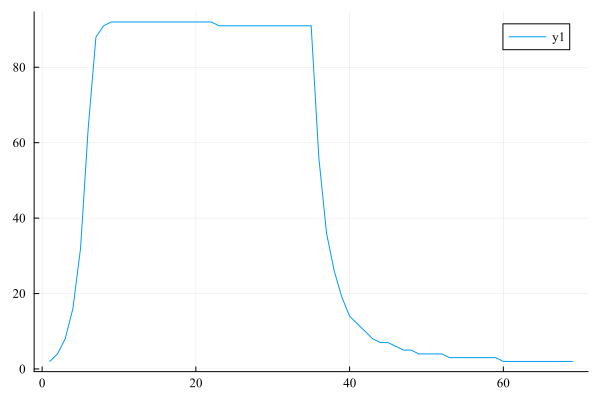

In [120]:
plot(linkdims(mps_QFT))

In [32]:
mps_fk = truncate!(zipup_MPS_MPS_from_left(mps_f, mps_QFT))

MPS
[1] ((dim=2|id=404|"n=21"), (dim=2|id=349|"l=21,link"))
[2] ((dim=2|id=36|"n=22"), (dim=4|id=51|"l=22,link"), (dim=2|id=349|"l=21,link"))
[3] ((dim=2|id=455|"n=23"), (dim=8|id=56|"l=23,link"), (dim=4|id=51|"l=22,link"))
[4] ((dim=2|id=871|"n=24"), (dim=16|id=310|"l=24,link"), (dim=8|id=56|"l=23,link"))
[5] ((dim=2|id=539|"n=25"), (dim=15|id=128|"l=25,link"), (dim=16|id=310|"l=24,link"))
[6] ((dim=2|id=110|"n=26"), (dim=12|id=614|"l=26,link"), (dim=15|id=128|"l=25,link"))
[7] ((dim=2|id=648|"n=27"), (dim=10|id=250|"l=27,link"), (dim=12|id=614|"l=26,link"))
[8] ((dim=2|id=611|"n=28"), (dim=8|id=628|"l=28,link"), (dim=10|id=250|"l=27,link"))
[9] ((dim=2|id=96|"n=29"), (dim=7|id=440|"l=29,link"), (dim=8|id=628|"l=28,link"))
[10] ((dim=2|id=367|"n=30"), (dim=7|id=783|"l=30,link"), (dim=7|id=440|"l=29,link"))
[11] ((dim=2|id=531|"n=31"), (dim=6|id=398|"l=31,link"), (dim=7|id=783|"l=30,link"))
[12] ((dim=2|id=755|"n=32"), (dim=5|id=803|"l=32,link"), (dim=6|id=398|"l=31,link"))
[13] ((dim=

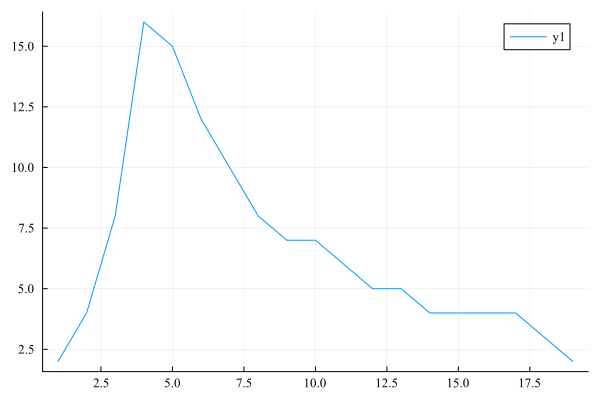

In [33]:
plot(linkdims(mps_fk))

In [49]:
Fk = []
k_range = LinRange(-x_max,x_max,3500)
for k in k_range
    s = c2b(k/(2k_max) + 1/2 ,Lk) 
    push!(Fk , evaluate(mps_fk,s)/2^(Lx))
end

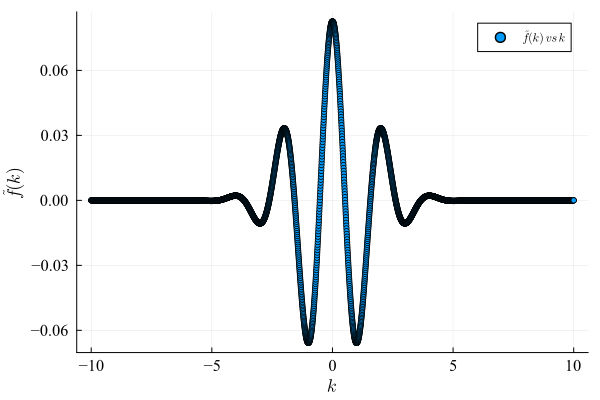

In [57]:
using Plots
using LaTeXStrings

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")

scatter(k_range, real.(Fk), label=L"\tilde{f}(k) \, \textit{vs} \,k", xlabel=L"k", ylabel=L"\tilde{f}(k)", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10, markersize = 3)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot
    


In [122]:
function QFT_mps(n::Int, x_max, k_max)
    Lx = n
    Lk = n

    L = Int(Lk + Lx)
    g(x,k) = exp(1im * k * x)
    function f(v)
        x0 = b2c(v[1:Lx])
        k0 = b2c(v[Lx+1:end])
        x = 2*x_max * (x0-1/2)
        k = 2*k_max * (k0-1/2)
        return g(x,k)
    end

    localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

    tolerance = 1e-11

    tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance, maxbonddim = 250)

    mps_QFT = MPS(tci)
    return mps_QFT
end

mps_QFT = QFT_mps(n,10,10)





MPS
[1] ((dim=2|id=73|"n=1"), (dim=2|id=807|"l=1,link"))
[2] ((dim=2|id=807|"l=1,link"), (dim=2|id=945|"n=2"), (dim=4|id=328|"l=2,link"))
[3] ((dim=4|id=328|"l=2,link"), (dim=2|id=850|"n=3"), (dim=8|id=115|"l=3,link"))
[4] ((dim=8|id=115|"l=3,link"), (dim=2|id=899|"n=4"), (dim=16|id=565|"l=4,link"))
[5] ((dim=16|id=565|"l=4,link"), (dim=2|id=140|"n=5"), (dim=32|id=662|"l=5,link"))
[6] ((dim=32|id=662|"l=5,link"), (dim=2|id=674|"n=6"), (dim=64|id=738|"l=6,link"))
[7] ((dim=64|id=738|"l=6,link"), (dim=2|id=475|"n=7"), (dim=89|id=672|"l=7,link"))
[8] ((dim=89|id=672|"l=7,link"), (dim=2|id=129|"n=8"), (dim=91|id=89|"l=8,link"))
[9] ((dim=91|id=89|"l=8,link"), (dim=2|id=757|"n=9"), (dim=92|id=803|"l=9,link"))
[10] ((dim=92|id=803|"l=9,link"), (dim=2|id=251|"n=10"), (dim=92|id=102|"l=10,link"))
[11] ((dim=92|id=102|"l=10,link"), (dim=2|id=310|"n=11"), (dim=92|id=779|"l=11,link"))
[12] ((dim=92|id=779|"l=11,link"), (dim=2|id=635|"n=12"), (dim=92|id=295|"l=12,link"))
[13] ((dim=92|id=295|"l=12

In [123]:
function FT_fun(g, x_max, max_bond)
    L = n
    function f(v)
        x = b2c(v)
        y = 2*x_max * (x- 1/2)
        return g(y)
    end

    localdims = fill(2, L)  # Fill the tensor with dimensions of size 2

    tolerance = 1e-11

    tci, ranks, errors = TCI.crossinterpolate2(ComplexF64, f, localdims; tolerance=tolerance, maxbonddim = max_bond)

    mps_f = MPS(tci)
    mps_fk = truncate!(zipup_MPS_MPS_from_left(mps_f, mps_QFT))
    return mps_fk
end

FT_fun (generic function with 2 methods)

In [124]:
g(x) =  cos(3x)
mps_fk = FT_fun(g,10,100)

MPS
[1] ((dim=2|id=267|"n=36"), (dim=2|id=459|"l=36,link"))
[2] ((dim=2|id=540|"n=37"), (dim=4|id=446|"l=37,link"), (dim=2|id=459|"l=36,link"))
[3] ((dim=2|id=806|"n=38"), (dim=8|id=9|"l=38,link"), (dim=4|id=446|"l=37,link"))
[4] ((dim=2|id=217|"n=39"), (dim=16|id=213|"l=39,link"), (dim=8|id=9|"l=38,link"))
[5] ((dim=2|id=541|"n=40"), (dim=15|id=829|"l=40,link"), (dim=16|id=213|"l=39,link"))
[6] ((dim=2|id=333|"n=41"), (dim=12|id=848|"l=41,link"), (dim=15|id=829|"l=40,link"))
[7] ((dim=2|id=621|"n=42"), (dim=10|id=349|"l=42,link"), (dim=12|id=848|"l=41,link"))
[8] ((dim=2|id=754|"n=43"), (dim=8|id=723|"l=43,link"), (dim=10|id=349|"l=42,link"))
[9] ((dim=2|id=709|"n=44"), (dim=7|id=881|"l=44,link"), (dim=8|id=723|"l=43,link"))
[10] ((dim=2|id=870|"n=45"), (dim=7|id=337|"l=45,link"), (dim=7|id=881|"l=44,link"))
[11] ((dim=2|id=415|"n=46"), (dim=6|id=532|"l=46,link"), (dim=7|id=337|"l=45,link"))
[12] ((dim=2|id=334|"n=47"), (dim=5|id=31|"l=47,link"), (dim=6|id=532|"l=46,link"))
[13] ((dim

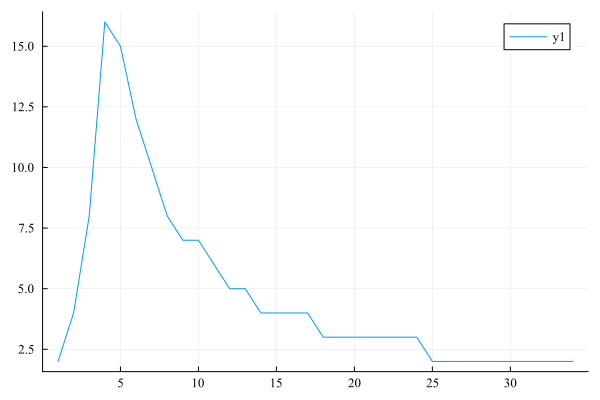

In [125]:
plot(linkdims(mps_fk))

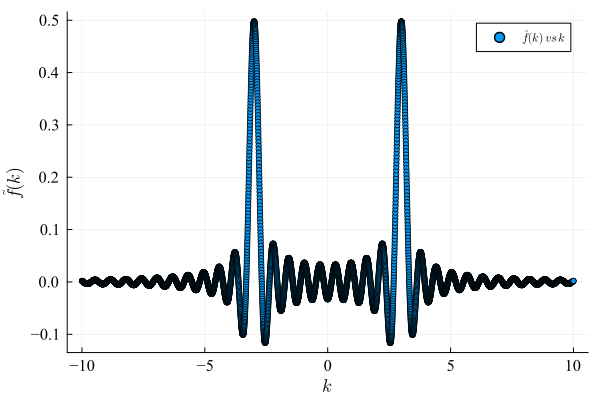

In [126]:
Fk = []
k_range = LinRange(-x_max,x_max,6500)
for k in k_range
    s = c2b(k/(2k_max) + 1/2 ,Lk) 
    push!(Fk , evaluate(mps_fk,s)/2^(Lx))
end
using Plots
using LaTeXStrings

# Set default font family (Times New Roman) and apply individual font sizes
default(fontfamily="Times New Roman")

scatter(k_range, real.(Fk), label=L"\tilde{f}(k) \, \textit{vs} \,k", xlabel=L"k", ylabel=L"\tilde{f}(k)", 
    legend=:topright, grid=true,
    titlefont=14, guidefont=12, tickfont=10, markersize = 3)  # Set fonts for title, axis labels, and ticks

    # Overlay the exact function plot